In [1]:
import sys
sys.path.insert(0, '../../../Utilities/')
import argparse
import os
import torch
from collections import OrderedDict
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import seaborn as sns
import pylab as py
import time
from pyDOE import lhs
import warnings
sys.path.insert(0, '../../../Scripts/')
from models_pde import Generator, Discriminator, Q_Net
from pid import *
# from ../Scripts/helper import *

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Hyper-parameters

In [3]:
num_epochs = 50000
lambda_val = 0.1
lambda_q = 0.5

noise = 0.0


#architecture for the models
d_hid_dim = 50 
d_num_layer = 2

g_hid_dim = 50
g_num_layer = 4

q_hid_dim = 50
q_num_layer = 4

### Load Data

In [4]:
    
# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 50
N_b = 50
N_f = 10000
# layers = [2, 100, 100, 100, 100, 2]

data = scipy.io.loadmat('../../../datasets/NLS.mat')

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

###########################

idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

X_f = lb + (ub-lb)*lhs(2, N_f)

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
Y0 = np.concatenate((u0,v0), 1) 
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)

#### Models

In [5]:
D = Discriminator(in_dim = 6, out_dim = 1, hid_dim = d_hid_dim, num_layers = d_num_layer).to(device)
G = Generator(in_dim = 3, out_dim = 2, hid_dim = g_hid_dim, num_layers = g_num_layer).to(device)
Q = Q_Net(in_dim = 4, out_dim = 1, hid_dim = q_hid_dim, num_layers = q_num_layer).to(device)

In [6]:
PID = Schrodinger_PID(X0, Y0, X_f, X_lb, X_ub, X_star, h_star, G, D, Q, device, num_epochs, lambda_val, noise)

### Training

In [7]:
error_h_hist, error_f_hist = PID.train()

[Epoch 0/50000] [MSE loss: 0.416410] [G loss: 0.962024] [D loss: 2.787611] [Q loss: 1.174457] [Adv G loss: 0.372288] [Err h: 9.061595e-01] [Residual_f: 5.522301e-04]
[Epoch 100/50000] [MSE loss: 0.186533] [G loss: 0.353008] [D loss: 2.778481] [Q loss: 1.333393] [Adv G loss: -0.049100] [Err h: 7.000452e-01] [Residual_f: 3.876671e-01]
[Epoch 200/50000] [MSE loss: 0.510457] [G loss: 0.758771] [D loss: 2.669520] [Q loss: 1.208477] [Adv G loss: 0.133426] [Err h: 1.174776e+00] [Residual_f: 1.411055e+01]
[Epoch 300/50000] [MSE loss: 0.263346] [G loss: 0.543489] [D loss: 2.760353] [Q loss: 0.802663] [Adv G loss: 0.003721] [Err h: 7.223996e-01] [Residual_f: 1.353458e-02]
[Epoch 400/50000] [MSE loss: 0.314537] [G loss: 0.108542] [D loss: 2.772564] [Q loss: 0.196254] [Adv G loss: -0.027625] [Err h: 6.908992e-01] [Residual_f: 1.778132e-01]
[Epoch 500/50000] [MSE loss: 0.364816] [G loss: 0.149514] [D loss: 2.723299] [Q loss: 0.076803] [Adv G loss: 0.046325] [Err h: 7.102379e-01] [Residual_f: 2.2487

In [10]:
nsamples = 500
u_pred_list = []
v_pred_list = []
h_pred_list = []
f_u_pred_list = []
f_v_pred_list = []
for run in range(nsamples):
    u_pred, v_pred, f_u_pred, f_v_pred = PID.predict(X_star)
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    u_pred_list.append(u_pred)
    v_pred_list.append(v_pred)
    f_u_pred_list.append(f_u_pred)
    f_v_pred_list.append(f_v_pred)
    h_pred_list.append(h_pred)


u_pred_arr = np.array(u_pred_list)
v_pred_arr = np.array(v_pred_list)
f_u_pred_arr = np.array(f_u_pred_list)
f_v_pred_arr = np.array(f_v_pred_list)
h_pred_arr = np.array(h_pred_list)

u_pred = u_pred_arr.mean(axis=0)
v_pred = v_pred_arr.mean(axis=0)
f_u_pred = f_u_pred_arr.mean(axis=0)
f_v_pred = f_v_pred_arr.mean(axis=0)
h_pred = h_pred_arr.mean(axis=0)

h_pred_var = h_pred_arr.var(axis=0)
residual = (f_u_pred**2).mean() + (f_v_pred**2).mean()

#     u_dev = u_pred_arr.var(axis=0)
#     f_dev = f_pred_arr.var(axis=0)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
H_pred_var = griddata(X_star, h_pred_var.flatten(), (X, T), method='cubic')

FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')

In [11]:
print("Error u:", error_u)
print("Error v:", error_v)
print("Error h:", error_h)                   
print('Residual: %e' % (residual))

Error u: 1.066990048186867
Error v: 1.2783652446156633
Error h: 0.38754547554753405
Residual: 9.567341e-01


Text(0.5, 1.0, '$Variance |h(t,x)|$')

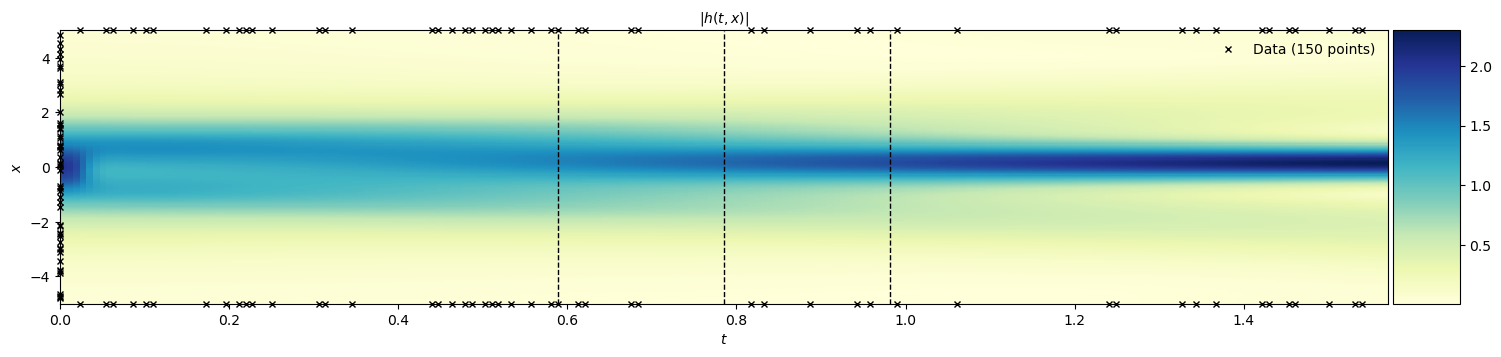

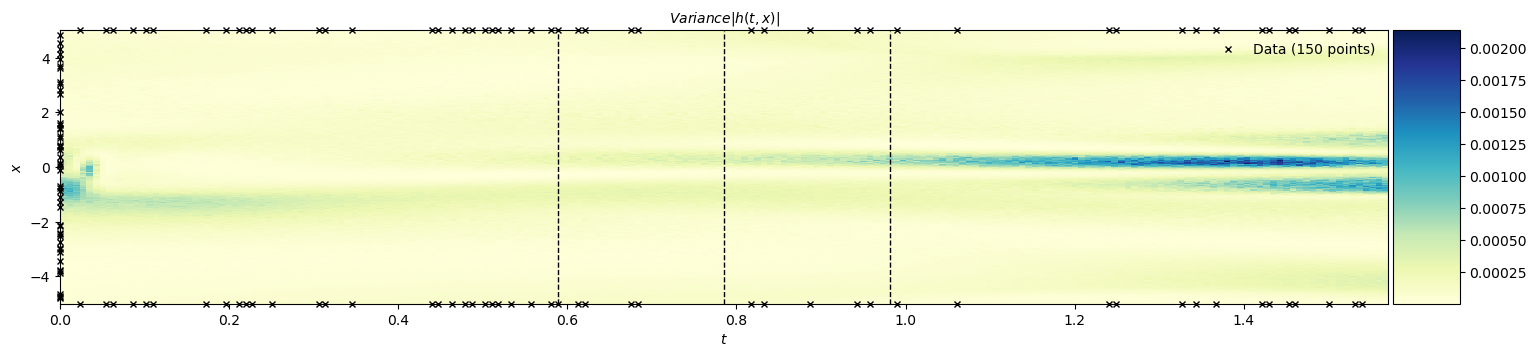

In [12]:
######################################################################
############################# Plotting ###############################
######################################################################    
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

# fig, ax = newfig(1.0, 0.9)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$|h(t,x)|$', fontsize = 10)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred_var.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$Variance |h(t,x)|$', fontsize = 10)




Text(0.5, 1.0, '$t = 0.98$')

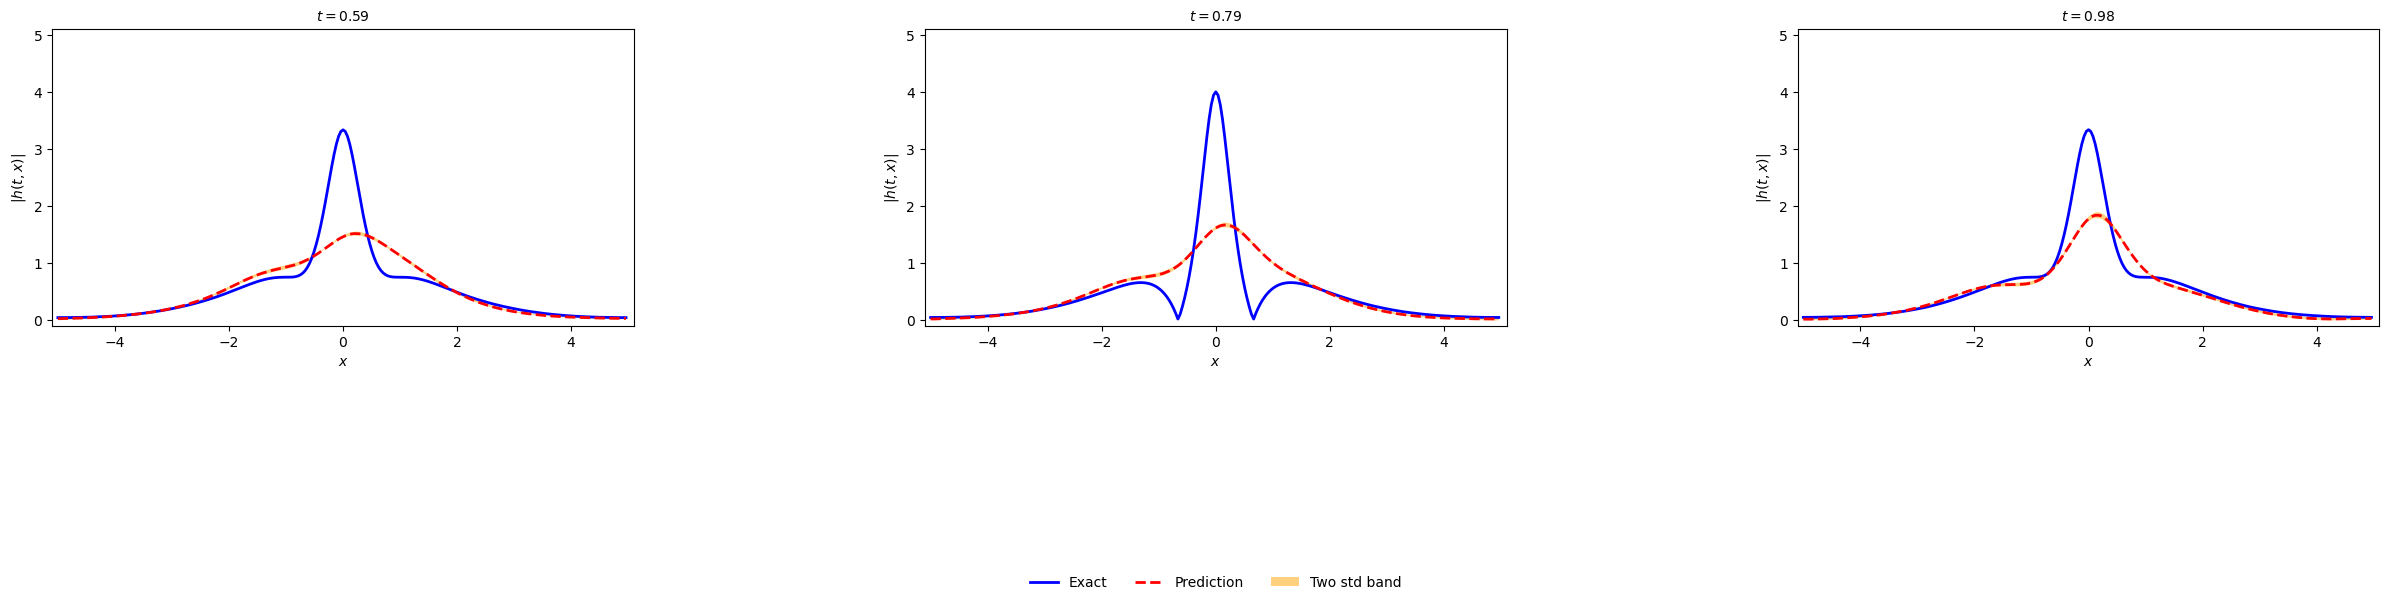

In [13]:
####### Row 1: h(t,x) slices ##################    
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[75,:] - 2.0*np.sqrt(H_pred_var[75,:])
upper = H_pred[75,:] + 2.0*np.sqrt(H_pred_var[75,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[100,:] - 2.0*np.sqrt(H_pred_var[100,:])
upper = H_pred[100,:] + 2.0*np.sqrt(H_pred_var[100,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[125,:] - 2.0*np.sqrt(H_pred_var[125,:])
upper = H_pred[125,:] + 2.0*np.sqrt(H_pred_var[125,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)

[Epoch 0/50000] [MSE loss: 0.000493] [G loss: 0.794913] [D loss: 2.700754] [Q loss: 0.019926] [Adv G loss: 0.785923] [Err h: 3.877357e-01] [Residual_f: 9.576100e-01]
[Epoch 100/50000] [MSE loss: 0.000681] [G loss: 0.747384] [D loss: 2.675760] [Q loss: 0.018169] [Adv G loss: 0.739424] [Err h: 3.871905e-01] [Residual_f: 9.411835e-01]
[Epoch 200/50000] [MSE loss: 0.000704] [G loss: 0.582141] [D loss: 2.646255] [Q loss: 0.019936] [Adv G loss: 0.574483] [Err h: 3.868415e-01] [Residual_f: 9.541177e-01]
[Epoch 300/50000] [MSE loss: 0.000468] [G loss: 0.784315] [D loss: 2.682933] [Q loss: 0.008642] [Adv G loss: 0.778530] [Err h: 3.870013e-01] [Residual_f: 9.441715e-01]
[Epoch 400/50000] [MSE loss: 0.000400] [G loss: 0.776704] [D loss: 2.686058] [Q loss: 0.012919] [Adv G loss: 0.769553] [Err h: 3.873009e-01] [Residual_f: 9.530277e-01]
[Epoch 500/50000] [MSE loss: 0.000411] [G loss: 0.825085] [D loss: 2.684313] [Q loss: 0.009173] [Adv G loss: 0.817524] [Err h: 3.876492e-01] [Residual_f: 9.531941

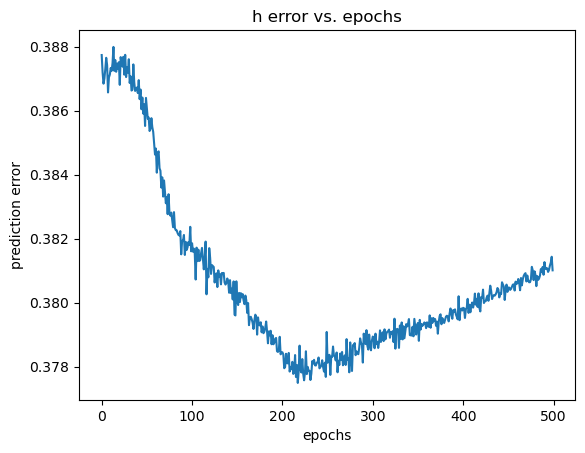

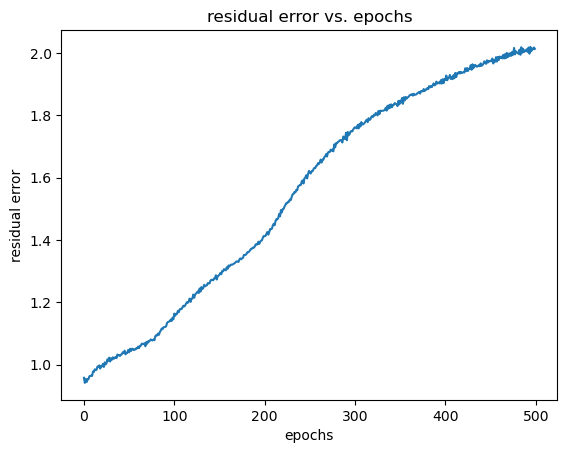

Error u: 1.0817643934225685
Error v: 1.2925479359623155
Error h: 0.38125301989775645
Residual: 2.015018e+00


Text(0.5, 1.0, '$t = 0.98$')

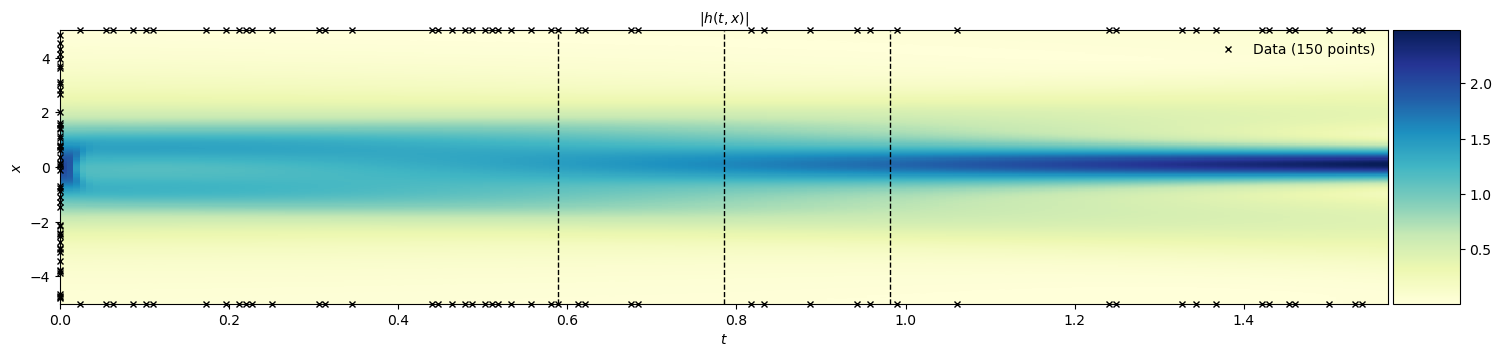

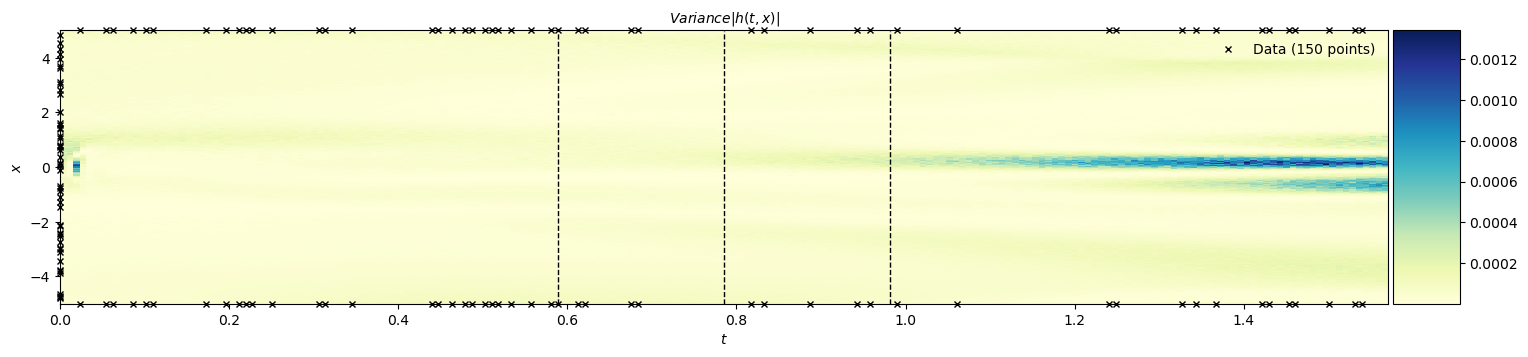

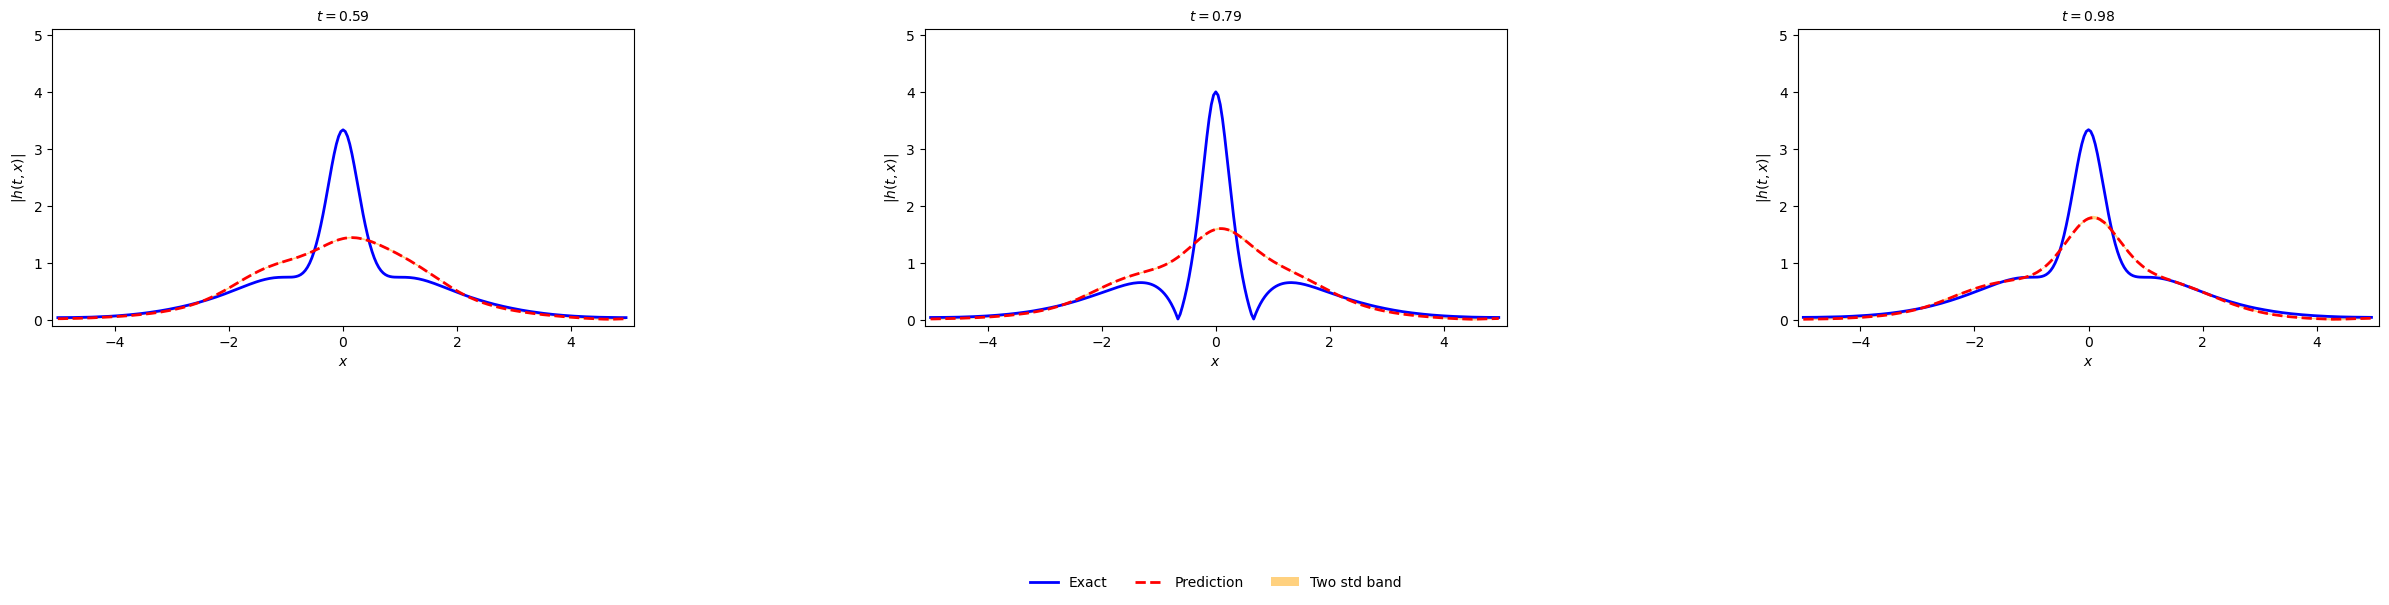

In [14]:
error_h_hist, error_f_hist = PID.train()

# plotting the points  
plt.plot(list(range(0,len(error_h_hist))), error_h_hist) 
  
# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('prediction error') 
  
# giving a title to my graph 
plt.title('h error vs. epochs') 
  
# function to show the plot 
plt.show() 

# plotting the points  
plt.plot(list(range(0,len(error_f_hist))), error_f_hist) 
  
# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('residual error') 
  
# giving a title to my graph 
plt.title('residual error vs. epochs') 
  
# function to show the plot 
plt.show()


nsamples = 500
u_pred_list = []
v_pred_list = []
h_pred_list = []
f_u_pred_list = []
f_v_pred_list = []
for run in range(nsamples):
    u_pred, v_pred, f_u_pred, f_v_pred = PID.predict(X_star)
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    u_pred_list.append(u_pred)
    v_pred_list.append(v_pred)
    f_u_pred_list.append(f_u_pred)
    f_v_pred_list.append(f_v_pred)
    h_pred_list.append(h_pred)


u_pred_arr = np.array(u_pred_list)
v_pred_arr = np.array(v_pred_list)
f_u_pred_arr = np.array(f_u_pred_list)
f_v_pred_arr = np.array(f_v_pred_list)
h_pred_arr = np.array(h_pred_list)

u_pred = u_pred_arr.mean(axis=0)
v_pred = v_pred_arr.mean(axis=0)
f_u_pred = f_u_pred_arr.mean(axis=0)
f_v_pred = f_v_pred_arr.mean(axis=0)
h_pred = h_pred_arr.mean(axis=0)

h_pred_var = h_pred_arr.var(axis=0)
residual = (f_u_pred**2).mean() + (f_v_pred**2).mean()

#     u_dev = u_pred_arr.var(axis=0)
#     f_dev = f_pred_arr.var(axis=0)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
H_pred_var = griddata(X_star, h_pred_var.flatten(), (X, T), method='cubic')

FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')

print("Error u:", error_u)
print("Error v:", error_v)
print("Error h:", error_h)                   
print('Residual: %e' % (residual))

######################################################################
############################# Plotting ###############################
######################################################################    
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

# fig, ax = newfig(1.0, 0.9)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$|h(t,x)|$', fontsize = 10)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred_var.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$Variance |h(t,x)|$', fontsize = 10)


####### Row 1: h(t,x) slices ##################    
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[75,:] - 2.0*np.sqrt(H_pred_var[75,:])
upper = H_pred[75,:] + 2.0*np.sqrt(H_pred_var[75,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[100,:] - 2.0*np.sqrt(H_pred_var[100,:])
upper = H_pred[100,:] + 2.0*np.sqrt(H_pred_var[100,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[125,:] - 2.0*np.sqrt(H_pred_var[125,:])
upper = H_pred[125,:] + 2.0*np.sqrt(H_pred_var[125,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)


In [15]:
error_h_hist, error_f_hist = PID.train()

# plotting the points  
plt.plot(list(range(0,len(error_h_hist))), error_h_hist) 
  
# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('prediction error') 
  
# giving a title to my graph 
plt.title('h error vs. epochs') 
  
# function to show the plot 
plt.show() 

# plotting the points  
plt.plot(list(range(0,len(error_f_hist))), error_f_hist) 
  
# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('residual error') 
  
# giving a title to my graph 
plt.title('residual error vs. epochs') 
  
# function to show the plot 
plt.show()


nsamples = 500
u_pred_list = []
v_pred_list = []
h_pred_list = []
f_u_pred_list = []
f_v_pred_list = []
for run in range(nsamples):
    u_pred, v_pred, f_u_pred, f_v_pred = PID.predict(X_star)
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    u_pred_list.append(u_pred)
    v_pred_list.append(v_pred)
    f_u_pred_list.append(f_u_pred)
    f_v_pred_list.append(f_v_pred)
    h_pred_list.append(h_pred)


u_pred_arr = np.array(u_pred_list)
v_pred_arr = np.array(v_pred_list)
f_u_pred_arr = np.array(f_u_pred_list)
f_v_pred_arr = np.array(f_v_pred_list)
h_pred_arr = np.array(h_pred_list)

u_pred = u_pred_arr.mean(axis=0)
v_pred = v_pred_arr.mean(axis=0)
f_u_pred = f_u_pred_arr.mean(axis=0)
f_v_pred = f_v_pred_arr.mean(axis=0)
h_pred = h_pred_arr.mean(axis=0)

h_pred_var = h_pred_arr.var(axis=0)
residual = (f_u_pred**2).mean() + (f_v_pred**2).mean()

#     u_dev = u_pred_arr.var(axis=0)
#     f_dev = f_pred_arr.var(axis=0)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
H_pred_var = griddata(X_star, h_pred_var.flatten(), (X, T), method='cubic')

FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')

print("Error u:", error_u)
print("Error v:", error_v)
print("Error h:", error_h)                   
print('Residual: %e' % (residual))

######################################################################
############################# Plotting ###############################
######################################################################    
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

# fig, ax = newfig(1.0, 0.9)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$|h(t,x)|$', fontsize = 10)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred_var.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$Variance |h(t,x)|$', fontsize = 10)


####### Row 1: h(t,x) slices ##################    
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[75,:] - 2.0*np.sqrt(H_pred_var[75,:])
upper = H_pred[75,:] + 2.0*np.sqrt(H_pred_var[75,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[100,:] - 2.0*np.sqrt(H_pred_var[100,:])
upper = H_pred[100,:] + 2.0*np.sqrt(H_pred_var[100,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[125,:] - 2.0*np.sqrt(H_pred_var[125,:])
upper = H_pred[125,:] + 2.0*np.sqrt(H_pred_var[125,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)


[Epoch 0/50000] [MSE loss: 0.000185] [G loss: 0.652344] [D loss: 2.714985] [Q loss: 0.003694] [Adv G loss: 0.646043] [Err h: 3.813426e-01] [Residual_f: 2.019806e+00]
[Epoch 100/50000] [MSE loss: 0.000139] [G loss: 0.831415] [D loss: 2.721743] [Q loss: 0.004524] [Adv G loss: 0.824329] [Err h: 3.812383e-01] [Residual_f: 2.015877e+00]
[Epoch 200/50000] [MSE loss: 0.000165] [G loss: 0.709090] [D loss: 2.720758] [Q loss: 0.004632] [Adv G loss: 0.702648] [Err h: 3.813195e-01] [Residual_f: 2.021636e+00]
[Epoch 300/50000] [MSE loss: 0.000210] [G loss: 0.583947] [D loss: 2.718152] [Q loss: 0.004641] [Adv G loss: 0.575751] [Err h: 3.810139e-01] [Residual_f: 2.015037e+00]
[Epoch 400/50000] [MSE loss: 0.000249] [G loss: 0.660329] [D loss: 2.719927] [Q loss: 0.009277] [Adv G loss: 0.650060] [Err h: 3.812956e-01] [Residual_f: 2.022494e+00]
[Epoch 500/50000] [MSE loss: 0.000497] [G loss: 0.697305] [D loss: 2.702901] [Q loss: 0.011225] [Adv G loss: 0.687371] [Err h: 3.811815e-01] [Residual_f: 2.017053

In [ ]:
error_h_hist, error_f_hist = PID.train()

# plotting the points  
plt.plot(list(range(0,len(error_h_hist))), error_h_hist) 
  
# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('prediction error') 
  
# giving a title to my graph 
plt.title('h error vs. epochs') 
  
# function to show the plot 
plt.show() 

# plotting the points  
plt.plot(list(range(0,len(error_f_hist))), error_f_hist) 
  
# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('residual error') 
  
# giving a title to my graph 
plt.title('residual error vs. epochs') 
  
# function to show the plot 
plt.show()


nsamples = 500
u_pred_list = []
v_pred_list = []
h_pred_list = []
f_u_pred_list = []
f_v_pred_list = []
for run in range(nsamples):
    u_pred, v_pred, f_u_pred, f_v_pred = PID.predict(X_star)
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    u_pred_list.append(u_pred)
    v_pred_list.append(v_pred)
    f_u_pred_list.append(f_u_pred)
    f_v_pred_list.append(f_v_pred)
    h_pred_list.append(h_pred)


u_pred_arr = np.array(u_pred_list)
v_pred_arr = np.array(v_pred_list)
f_u_pred_arr = np.array(f_u_pred_list)
f_v_pred_arr = np.array(f_v_pred_list)
h_pred_arr = np.array(h_pred_list)

u_pred = u_pred_arr.mean(axis=0)
v_pred = v_pred_arr.mean(axis=0)
f_u_pred = f_u_pred_arr.mean(axis=0)
f_v_pred = f_v_pred_arr.mean(axis=0)
h_pred = h_pred_arr.mean(axis=0)

h_pred_var = h_pred_arr.var(axis=0)
residual = (f_u_pred**2).mean() + (f_v_pred**2).mean()

#     u_dev = u_pred_arr.var(axis=0)
#     f_dev = f_pred_arr.var(axis=0)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
H_pred_var = griddata(X_star, h_pred_var.flatten(), (X, T), method='cubic')

FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')

print("Error u:", error_u)
print("Error v:", error_v)
print("Error h:", error_h)                   
print('Residual: %e' % (residual))

######################################################################
############################# Plotting ###############################
######################################################################    
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

# fig, ax = newfig(1.0, 0.9)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$|h(t,x)|$', fontsize = 10)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(H_pred_var.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('$Variance |h(t,x)|$', fontsize = 10)


####### Row 1: h(t,x) slices ##################    
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[75,:] - 2.0*np.sqrt(H_pred_var[75,:])
upper = H_pred[75,:] + 2.0*np.sqrt(H_pred_var[75,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[100,:] - 2.0*np.sqrt(H_pred_var[100,:])
upper = H_pred[100,:] + 2.0*np.sqrt(H_pred_var[100,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
lower = H_pred[125,:] - 2.0*np.sqrt(H_pred_var[125,:])
upper = H_pred[125,:] + 2.0*np.sqrt(H_pred_var[125,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)
